In [10]:
import numpy as np
import scipy.fft
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
by = np.load('./npy_files/By.npy')
x = np.load('./npy_files/x.npy')
y = np.load('./npy_files/y.npy')
t = np.load('./npy_files/t.npy')
print(x.shape)
print(by.shape)

(488,)
(700, 488, 1449)


In [12]:
YC = by.shape[0]//2
by = by[YC,:,:]

In [19]:
def build_fft(x, y, t, by):
    # Apply discrete fourier transform
    
    print("Allocating array %sx%s..." % by.shape, end="", flush=True)
    byfft = np.asarray(by, dtype="complex64")
    print("OK")
    
    # FW
    
    print("Applying discrete fast fourier transform...", end="", flush=True)
    scipy.fft.fftn(byfft,
                   axes=(0,1),
                   norm="forward",
                   overwrite_x=True)
    print("OK")
    
    print("Building freq grid...", end="", flush=True)
    # Build frequences grid
    freqx = np.fft.fftfreq(x.size, d=x[1] - x[0])
    freqt = np.fft.fftfreq(t.size, d=t[1] - t[0])

    KX, W = np.meshgrid(freqx, freqt, indexing='ij')
    print("OK")
    return KX, W, byfft

In [20]:
KX, W, byfft = build_fft(x, y, t, by)

Allocating array 488x1449...OK
Applying discrete fast fourier transform...OK
Building freq grid...OK


In [21]:
KZ2 = (W**2 - KX**2)  # On suppose KY = 0 en 2D...
KZ2 = KZ2
KZ2[KZ2 < 0] = 0.
KZ = np.sqrt(KZ2)

In [25]:
dz = t[1] - t[0]
propag = np.exp(-np.pi * 2j * KZ * dz)
propag[W < 0] = 0.  # Drop fréquences négatives (propagation inverse...)

In [26]:
#import matplotlib.pylab as plt
#import numpy as np
#import time
#from IPython import display

In [27]:
%matplotlib inline

frame = np.empty(byfft.shape)
for i in tqdm(range(t.shape[0])):
    byfft = byfft * propag
    v = scipy.fft.ifftn(byfft,
                        axes=(0,1))
    #if i % 10 == 0:
    #    # Display
    #    plt.imshow(np.real(v))
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    #    time.sleep(0.1)
    frame[:,t.shape[0] - 1 - i] = np.real(v)[:,0]


100%|██████████| 1449/1449 [01:20<00:00, 18.03it/s]


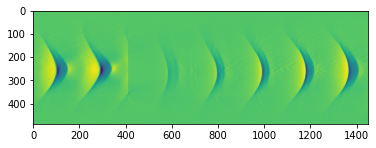

In [28]:
plt.imshow(frame)